<a href="https://colab.research.google.com/github/utkarshx27/Text_To_Image_And_Story_Generator/blob/main/Text_To_Image_And_Story_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade diffusers transformers -q

In [ ]:
!pip install gradio

In [ ]:
!pip install langchain

In [ ]:
!pip install openai

In [3]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from PIL import Image
import requests
import gradio as gr
from langchain import PromptTemplate, LLMChain, OpenAI
from transformers import BlipProcessor, BlipForConditionalGeneration

In [4]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [5]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token='hf_****************************', guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

unet/diffusion_pytorch_model.safetensors not found
Keyword arguments {'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image

  0%|          | 0/35 [00:00<?, ?it/s]

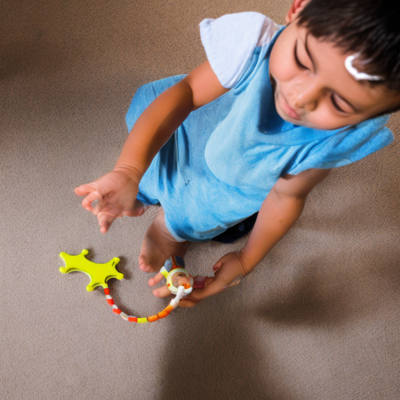

In [7]:
generate_image("boy playing with toy", image_gen_model)

In [13]:
generated_image = generate_image("boy playing with toy", image_gen_model)
generated_image.save("generated_image.png")

  0%|          | 0/35 [00:00<?, ?it/s]

In [16]:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

In [14]:
def generate_and_get_caption(image_path, image_gen_model):
    raw_image = Image.open(image_path).convert('RGB')

    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

    inputs = processor(raw_image, return_tensors="pt").to("cuda")

    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [17]:
image_path = "generated_image.png"
generated_caption = generate_and_get_caption(image_path, model)
print("Generated caption:", generated_caption)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated caption: a young boy holding a toy in his hands


In [48]:
OPENAI_API_KEY="sk-***************************************"
OpenAI.api_key=OPENAI_API_KEY

def generate_stroy(scenario):
  template = """
  You are a stroy teller,
  You can generate a short story based on simple narrative, the story should be not be more than 20 words;
  CONTEXT: {scenario}
  STORY:
  """

  prompt = PromptTemplate(template=template, input_variables=["scenario"])

  story_llm = LLMChain(llm = OpenAI(
      openai_api_key=OpenAI.api_key, temperature=1), prompt = prompt, verbose=True)

  story = story_llm.predict(scenario = scenario)

  print(story)
  return story

In [53]:
generate_stroy(generated_caption)